# Expoloring ARIMA models family performance in predicting ETH prices when models are trained on endogenous variables only.

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import r2_score, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


%matplotlib inline

In [2]:
## Setting random seed to be able to reproduce results. 
np.random.seed(42)

## IMPORTING DATA

#### Importing ETH prices

ETH price source: https://etherscan.io/chart/etherprice

In [3]:
## Importing ETH daily prices
df_eth = pd.read_csv('./Datasets/export-EtherPrice.csv')

In [4]:
df_eth.shape

(1287, 3)

In [5]:
df_eth.head(10)

,Date(UTC),UnixTimeStamp,Value
0,7/30/2015,1438214400,0.00
1,7/31/2015,1438300800,0.00
2,8/1/2015,1438387200,0.00
3,8/2/2015,1438473600,0.00
4,8/3/2015,1438560000,0.00
5,8/4/2015,1438646400,0.00
6,8/5/2015,1438732800,0.00
7,8/6/2015,1438819200,0.00
8,8/7/2015,1438905600,2.77
9,8/8/2015,1438992000,0.81


In [6]:
df_eth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1287 entries, 0 to 1286
Data columns (total 3 columns):
Date(UTC)        1287 non-null object
UnixTimeStamp    1287 non-null int64
Value            1287 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 30.2+ KB


In [7]:
## Checking how many years of data we have
1287/365

3.526027397260274

In [8]:
## Renaming columns
df_eth.rename({'Date(UTC)': 'Date', 'Value': 'eth_price'}, axis=1, inplace=True)

In [9]:
## Converting Dates from string type to Datetime format 
df_eth.Date = pd.to_datetime(df_eth.Date)

In [10]:
df_eth.head()

,Date,UnixTimeStamp,eth_price
0,2015-07-30,1438214400,0.0
1,2015-07-31,1438300800,0.0
2,2015-08-01,1438387200,0.0
3,2015-08-02,1438473600,0.0
4,2015-08-03,1438560000,0.0


In [11]:
## Setting Date as Index
df_eth.set_index('Date', inplace=True)

## ETH Price EDA

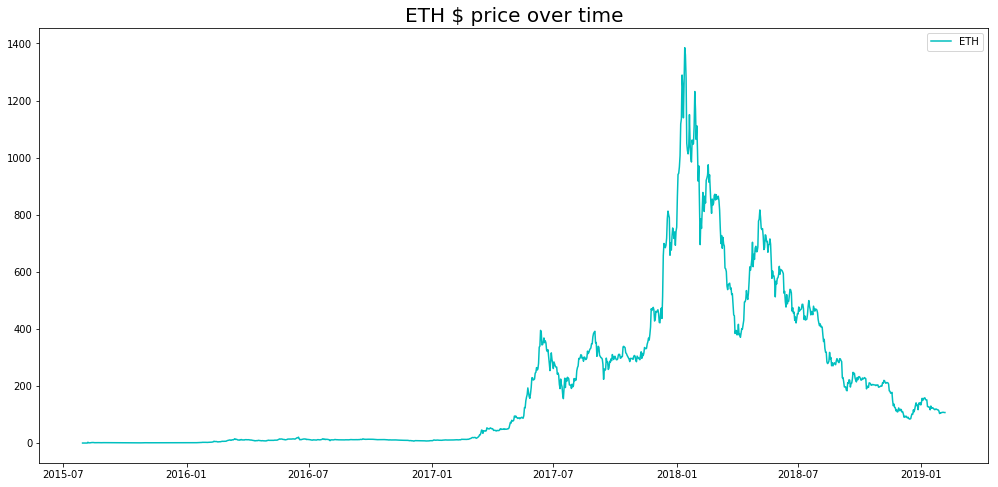

In [12]:
plt.figure(figsize=(17,8))
plt.plot(df_eth.index, df_eth.eth_price, label='ETH', c='c', linestyle='-')
plt.title('ETH $ price over time').set_fontsize(20)
plt.legend();

**Comment**:  
It seems pretty clear from the chart that ETH price is not stationary - it does not feature a constant mean overtime. Stationairty is a fundamental assumption of ARIMA models. We will likely need to difference.

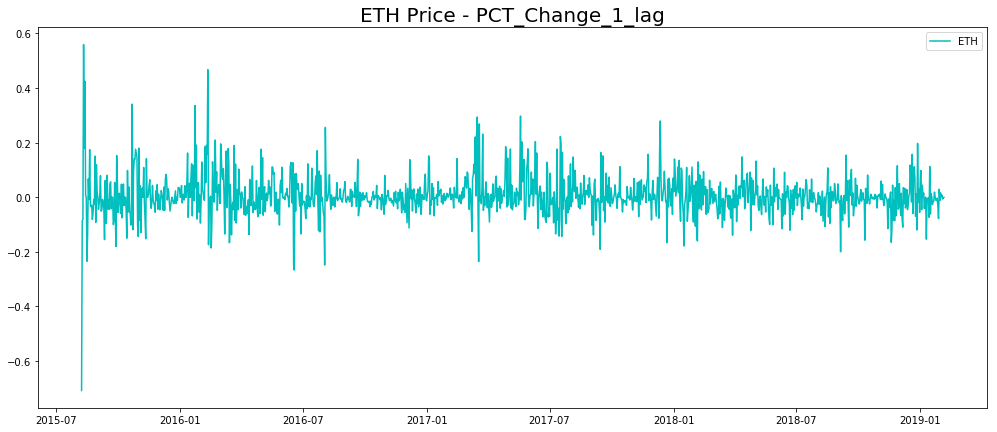

In [13]:
## Plotting ETH price percentage change with lag == 1
plt.figure(figsize=(17,7))
plt.plot(df_eth.index, df_eth.eth_price.pct_change(1), c='c', alpha=1, linestyle='-', label='ETH')
plt.title('ETH Price - PCT_Change_1_lag').set_fontsize(20)
plt.legend();

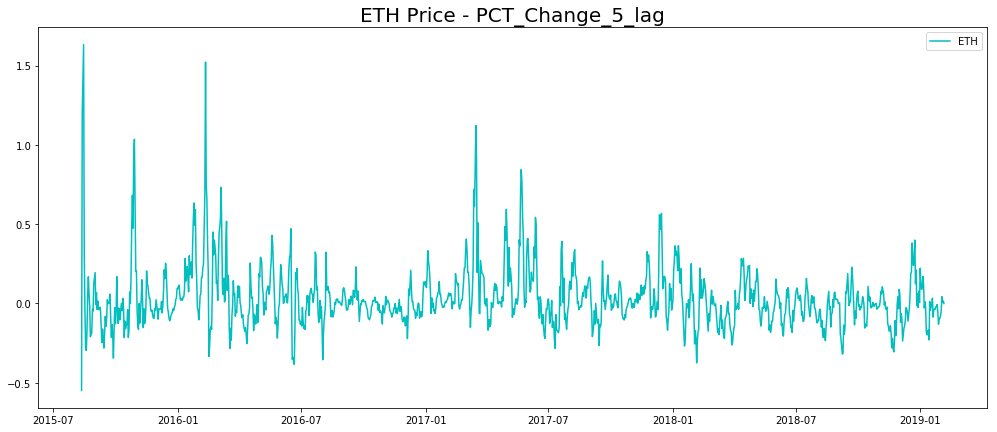

In [14]:
## Plotting ETH price percentage change with lag == 5
plt.figure(figsize=(17,7))
plt.plot(df_eth.index, df_eth.eth_price.pct_change(5), c='c', alpha=1, linestyle='-', label='ETH')
plt.title('ETH Price - PCT_Change_5_lag').set_fontsize(20)
plt.legend();

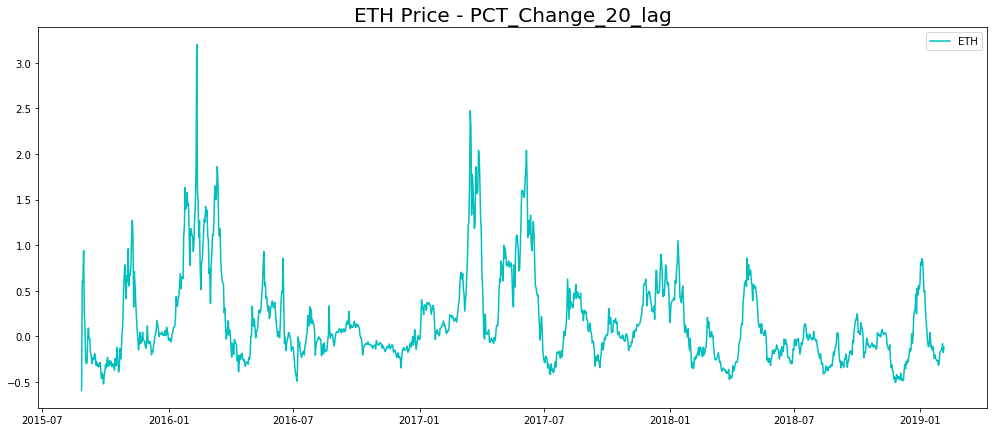

In [15]:
## Plotting ETH price percentage change with lag == 20
plt.figure(figsize=(17,7))
plt.plot(df_eth.index, df_eth.eth_price.pct_change(20), c='c', alpha=1, linestyle='-', label='ETH')
plt.title('ETH Price - PCT_Change_20_lag').set_fontsize(20)
plt.legend();

**Comment**  
ETH percentage price change seems stationary when lag == 1, and the less and the less when lag increases. Not a surprise if we look at ETH price change over time.

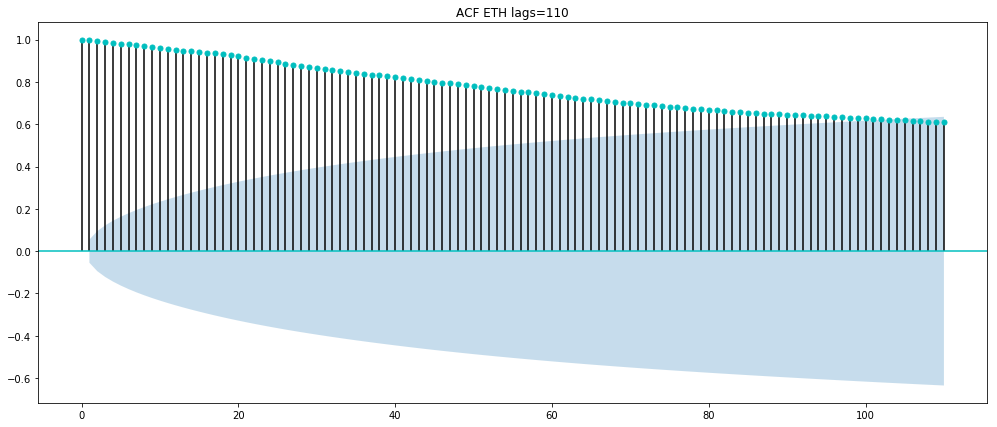

In [16]:
## Plotting ETH autocorrelation function. 
fig, ax = plt.subplots(figsize=(17,7))
plot_acf(df_eth.eth_price, lags=110, ax=ax, c='c')
plt.title('ACF ETH lags=110');

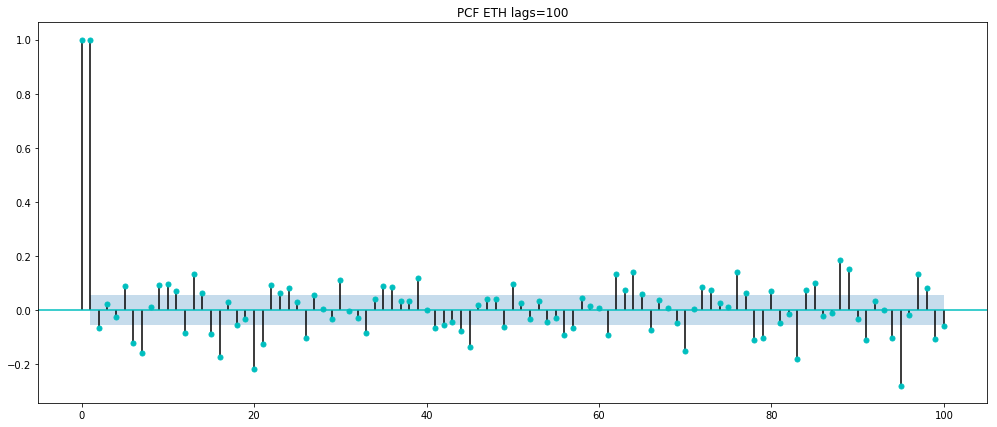

In [17]:
## Plotting ETH partical autocorrelation function, lags == 100
fig, ax = plt.subplots(figsize=(17,7))
plot_pacf(df_eth.eth_price, lags=100, ax=ax, c='c')
plt.title('PCF ETH lags=100');

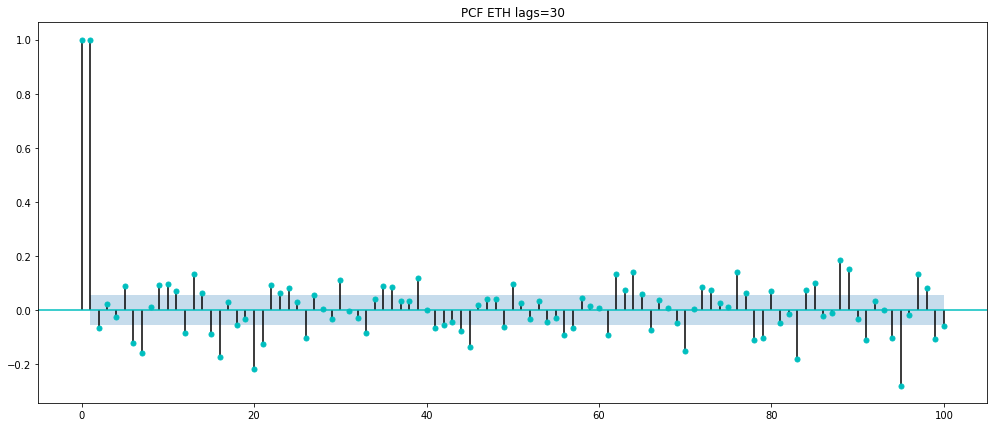

In [18]:
## Plotting ETH partical autocorrelation function, lags == 30
fig, ax = plt.subplots(figsize=(17,7))
plot_pacf(df_eth.eth_price, lags=100, ax=ax, c='c')

plt.title('PCF ETH lags=30');

/anaconda3/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


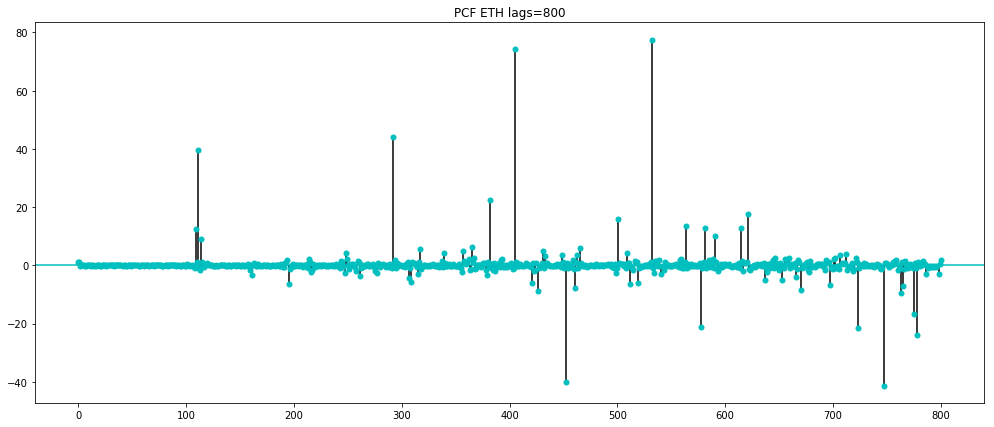

In [19]:
## Plotting ETH partical autocorrelation function, lags == 800
fig, ax = plt.subplots(figsize=(17,7))
plot_pacf(df_eth.eth_price, lags=800, ax=ax, c='c')
plt.title('PCF ETH lags=800');

**Comment**  
The price of ETH today appears to be significantly correlated with the price of ETH back in time even taking into consideration the correlation with previous times. 

In [20]:
# Import Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

In [21]:
# Define function to easily interpret the Augmented Dickey-Fuller test results.
def interpret_dftest(dftest):
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    return dfoutput

In [22]:
# Execute test on ETH price with diff=0
interpret_dftest(adfuller(df_eth.eth_price))

Test Statistic   -1.902010
p-value           0.331116
dtype: float64

In [23]:
# Execute test on ETH price with diff=1
interpret_dftest(adfuller(df_eth.eth_price.diff(1).dropna()))

Test Statistic   -6.368454e+00
p-value           2.377562e-08
dtype: float64

In [24]:
# Execute test diff=2
interpret_dftest(adfuller(df_eth.eth_price.diff(2).dropna()))

Test Statistic   -6.539775e+00
p-value           9.410132e-09
dtype: float64

In [25]:
# Execute test diff=3
interpret_dftest(adfuller(df_eth.eth_price.diff(3).dropna()))

Test Statistic   -6.189335e+00
p-value           6.177454e-08
dtype: float64

In [26]:
# Execute test diff=4
interpret_dftest(adfuller(df_eth.eth_price.diff(4).dropna()))

Test Statistic   -6.403786e+00
p-value           1.965958e-08
dtype: float64

**Comment**  
ETH price is not stationary. ETH price differenced by lag >= 1 is. 

## AUTOREGRESSION MODELING

### REGRESSION PROBLEM - PREDICTING ETH PRICE

In [27]:
df_eth.index

DatetimeIndex(['2015-07-30', '2015-07-31', '2015-08-01', '2015-08-02',
               '2015-08-03', '2015-08-04', '2015-08-05', '2015-08-06',
               '2015-08-07', '2015-08-08',
               ...
               '2019-01-27', '2019-01-28', '2019-01-29', '2019-01-30',
               '2019-01-31', '2019-02-01', '2019-02-02', '2019-02-03',
               '2019-02-04', '2019-02-05'],
              dtype='datetime64[ns]', name='Date', length=1287, freq=None)

In [28]:
## Determining the date where to split our dataset into train and test sets. 
##I will use the oldest 80% od the dataset observations for training and the remaining for testing.
df_eth.shape[0]*.8

1029.6000000000001

In [29]:
df_eth.shape

(1287, 2)

In [30]:
eth_train = df_eth.iloc[:1029, :]
eth_test  = df_eth.iloc[1029:, :]

#### Predicting on the whole Dataset with MA model - d==0, q==1

In [31]:
df_eth.head()

,UnixTimeStamp,eth_price
Date,,
2015-07-30,1438214400,0.0
2015-07-31,1438300800,0.0
2015-08-01,1438387200,0.0
2015-08-02,1438473600,0.0
2015-08-03,1438560000,0.0


In [32]:
## Instantiating the model
ma1 = ARIMA(endog = df_eth['eth_price'],
            order = (0, 0, 1), # (p, d, q)
            freq='D',
           dates=df_eth.index)

In [33]:
## Fitting the model
model = ma1.fit()

In [34]:
## Making predictions
preds = model.predict()

In [35]:
## Scoring
r2_score(df_eth.eth_price, pd.Series(preds))

0.7270371710257575

In [36]:
##Not bad!

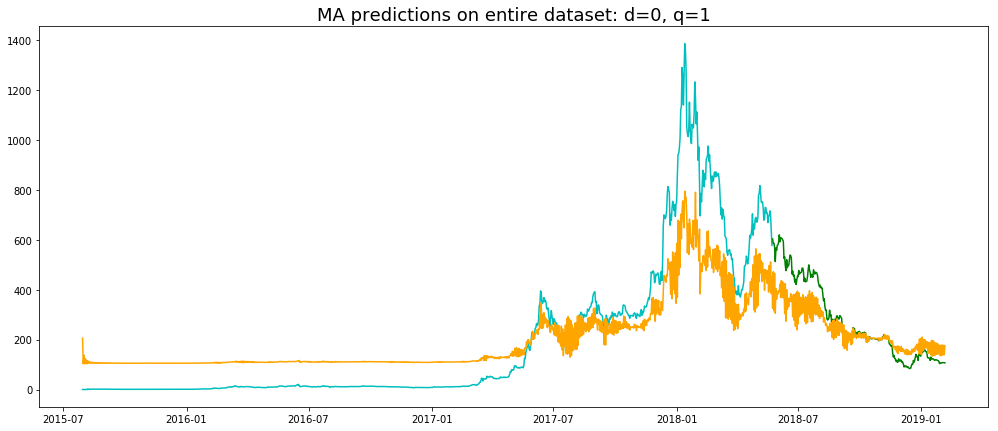

In [37]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'MA predictions on entire dataset: d=0, q=1', fontsize=18)
plt.show();

#### Predicting on the whole Dataset with MA model - d==1, q==1

In [38]:
## Instantiating the model
ma1 = ARIMA(endog = df_eth.eth_price,
            order = (0, 1, 1), # (p, d, q)
            freq='D',
           dates=df_eth.index)

In [39]:
## Fitting the model
model = ma1.fit()

In [40]:
## Making predictions
preds = model.predict()

In [41]:
## Scoring
r2_score(df_eth.eth_price[:1286], pd.Series(preds).dropna())

-0.5845890464505599

In [42]:
##Very bad!

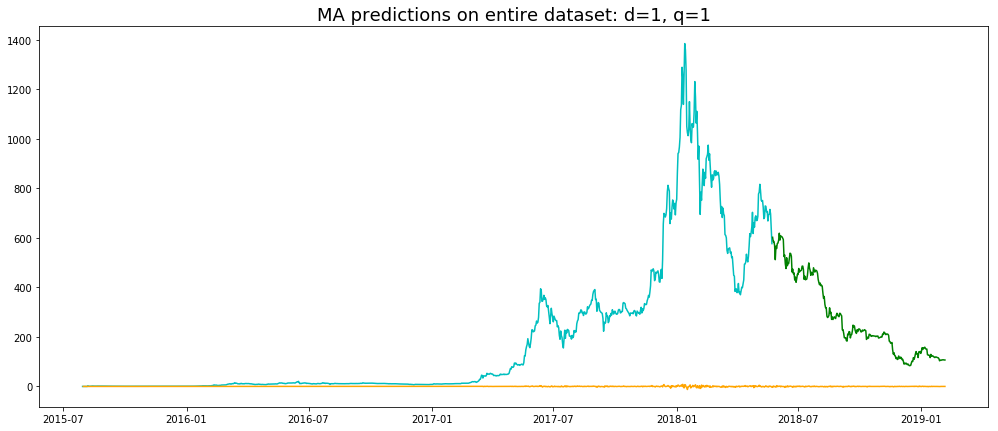

In [43]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'MA predictions on entire dataset: d=1, q=1', fontsize=18)
plt.show();

#### Validating MA model - d==0, q==1 - on test split

In [44]:
## Instantiating the model
ma1 = ARIMA(endog = eth_train.eth_price,
            order = (0, 0, 1), # (p, d, q)
            freq='D')

In [45]:
## Fitting the model on training data only!
model = ma1.fit()

In [46]:
## Making predictions
preds = model.predict(start=1029, end=1286)

In [47]:
#Scoring
r2_score(eth_test.eth_price, preds)

-0.29054859682541

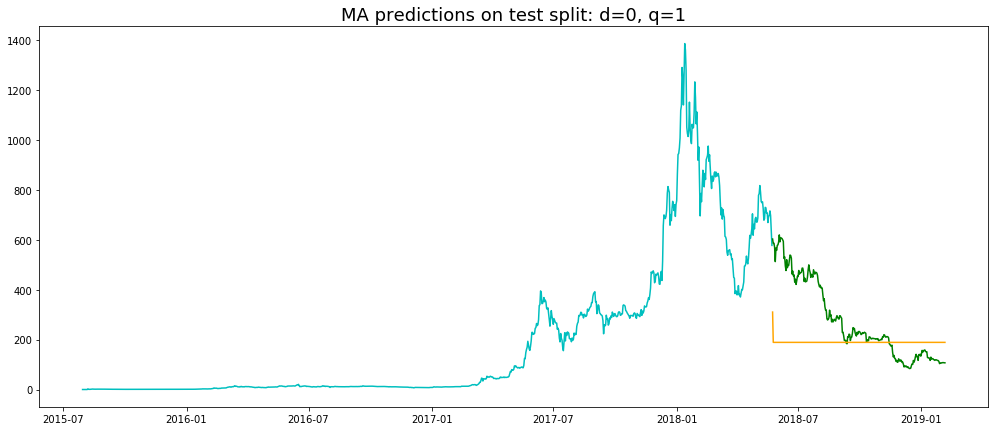

In [48]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'MA predictions on test split: d=0, q=1', fontsize=18)
plt.show();

In [49]:
## What a bad model!

#### Modelling with AR, p==1, d==0 and testing on test set

-0.9827081453440552


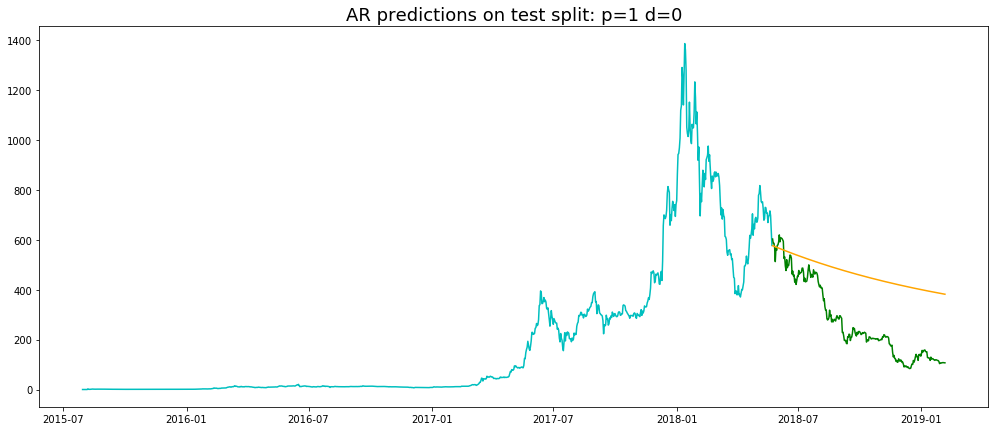

In [50]:
## Instantiating the model
ma1 = ARIMA(endog = eth_train.eth_price,
            order = (1, 0, 0), # (p, d, q)
            freq='D')

## Fitting the model on training data only!
model = ma1.fit()

## Making predictions
preds = model.predict(start=1029, end=1286)

#Scoring
print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'AR predictions on test split: p=1 d=0', fontsize=18)
plt.show();

In [51]:
#### Modelling with AR, p==1, d==1 and testing on test set

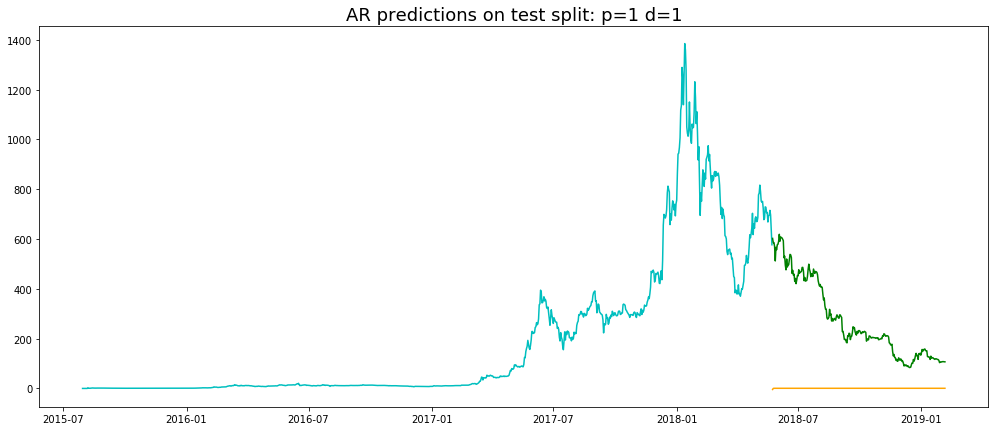

In [52]:
## Instantiating the model
ma1 = ARIMA(endog = eth_train.eth_price,
            order = (1, 1, 0), # (p, d, q)
            freq='D')

## Fitting the model on training data only!
model = ma1.fit()

## Making predictions
preds = model.predict(start=1029, end=1286)

#Scoring
r2_score(eth_test.eth_price, preds)

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'AR predictions on test split: p=1 d=1', fontsize=18)
plt.show();

**Comment**  
Both AR and MA perform badly alone. Both perform even worsely when differencing. 

#### Modelling with SARIMA to add a seasonal component to the model

In [53]:
## Instantiating the model
sarima = SARIMAX(endog=df_eth.eth_price,
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(0, 0, 0, 7)) # (P, D, Q, S)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [54]:
# Fitting SARIMA model on entire dataset.
model = sarima.fit()

In [55]:
# Generate predictions based on test set.
preds = model.predict()

In [56]:
r2_score(df_eth.eth_price, preds)

0.9934397601835505

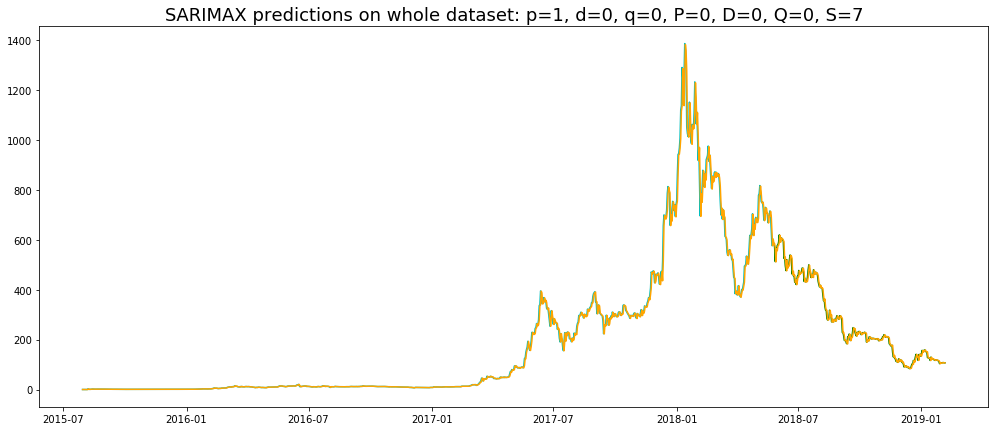

In [57]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on whole dataset: p=1, d=0, q=0, P=0, D=0, Q=0, S=7', fontsize=18)
plt.show();

**Comment**  
Clearly overfitting!

In [58]:
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(0, 0, 0, 7)) # (P, D, Q, S)

# Fitting SARIMA model on training dataset.
model = sarima.fit()

# Generate predictions
preds = model.predict(start=1029, end=1286)

# Scoring
print(r2_score(eth_test.eth_price, preds))

-0.6636941100832154


/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


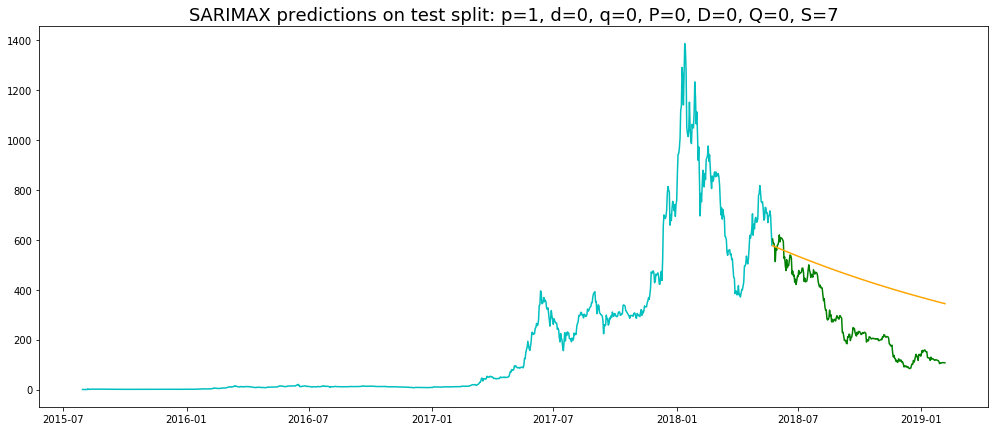

In [59]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=0, P=0, D=0, Q=0, S=7', fontsize=18)
plt.show();

Adding a seasonality component slightly improves our previous models. Performance is still very bad. 

In [60]:
## Instantiating new Sarima model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,1),              # (p, d, q)
                  seasonal_order=(1, 0, 0, 7)) # (P, D, Q, S)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [61]:
## Fitting SARIMA model.
model = sarima.fit()

In [62]:
## Generating predictions based on test set.
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

In [63]:
r2_score(eth_test.eth_price, preds)

-0.3117188868181304

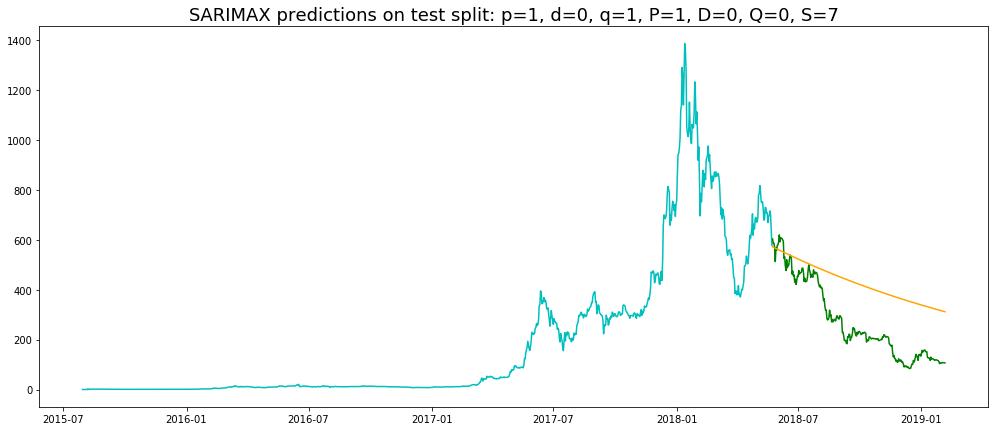

In [64]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=1, P=1, D=0, Q=0, S=7', fontsize=18)
plt.show();

In [65]:
## Code used to grid search and find best parameters of SARIMAX model: to deploy remove quotes.

'''%%time
# Starting r2 and (P, D, Q, S).

r2score = -90000 

final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for S in range(15):
    print(S)
    for P in range(5):
        print(P)
        for Q in range(5):
            print(Q)
            for D in range(5):
                print(D)
                try:
                    # Instantiate SARIMA model.
                    sarima = SARIMAX(endog = eth_train.eth_price,
                                     order = (1, 0, 0),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)

                    # Fit SARIMA model.
                    model = sarima.fit()

                    # Generate predictions based on training set.
                    # Start at time period 0 and end at 149.
                    preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

                    # Evaluate predictions.
                    print('The r2_scpre for 1, 0, 0 x{},{},{},{} is: {}'.format(P, D, Q, S, r2_score(eth_test.eth_price, preds)))

                    # Save for final report.
                    if r2score < r2_score(eth_test.eth_price, preds): #eth_test.eth_price[-100:], preds[-100:]
                        r2score = r2_score(eth_test.eth_price, preds) #eth_test.eth_price[-100:], preds[-100:]
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S


                except:
                    pass

print(f'Our model that maximizes r2_score on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q}, {final_S}).')
print(f'This model has a r2_score of {r2score}.')'''

"%%time\n# Starting r2 and (P, D, Q, S).\n\nr2score = -90000 \n\nfinal_P = 0\nfinal_D = 0\nfinal_Q = 0\nfinal_S = 0\n\nfor S in range(15):\n    print(S)\n    for P in range(5):\n        print(P)\n        for Q in range(5):\n            print(Q)\n            for D in range(5):\n                print(D)\n                try:\n                    # Instantiate SARIMA model.\n                    sarima = SARIMAX(endog = eth_train.eth_price,\n                                     order = (1, 0, 0),              # (p, d, q)\n                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)\n\n                    # Fit SARIMA model.\n                    model = sarima.fit()\n\n                    # Generate predictions based on training set.\n                    # Start at time period 0 and end at 149.\n                    preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])\n\n                    # Evaluate predictions.\n                    print('

#### Plotting best performing models from gridsearch

In [66]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,1),              # (p, d, q)
                  seasonal_order=(1, 0, 1, 5)) # (P, D, Q, S)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [67]:
## Fitting model.
model = sarima.fit()

In [68]:
## Generating predictions
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

In [69]:
r2_score(eth_test.eth_price, preds)

0.8485209479549221

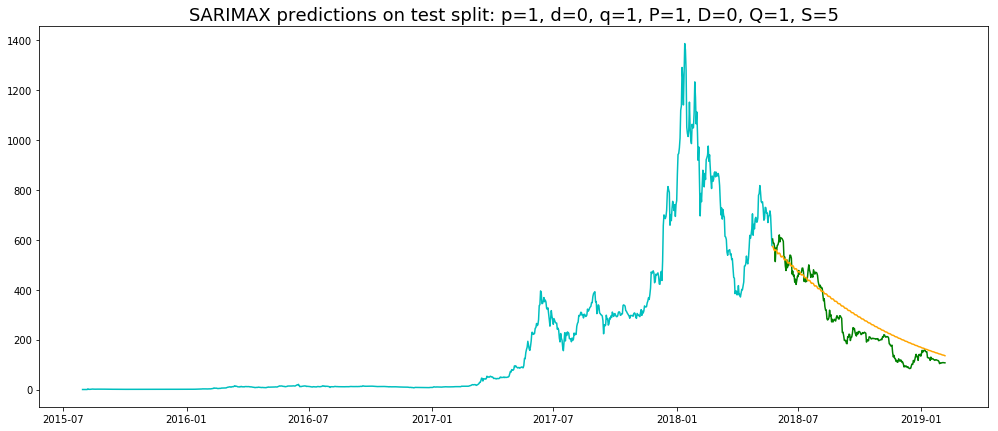

In [70]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=1, P=1, D=0, Q=1, S=5', fontsize=18)
plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.9216039681425557


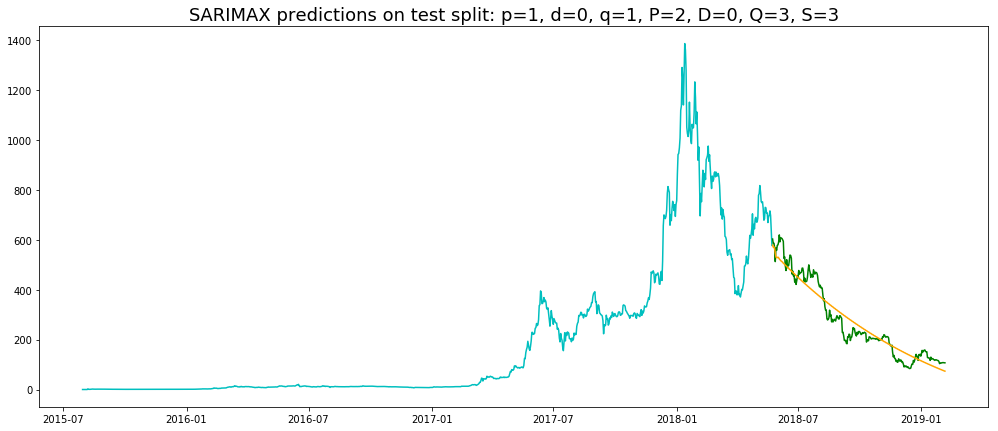

In [71]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,1),              # (p, d, q)
                  seasonal_order=(2, 0, 3, 3)) # (P, D, Q, S)

# Fitting model.
model = sarima.fit()

# Generating predictions
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=1, P=2, D=0, Q=3, S=3', fontsize=18)
plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.820363191657832


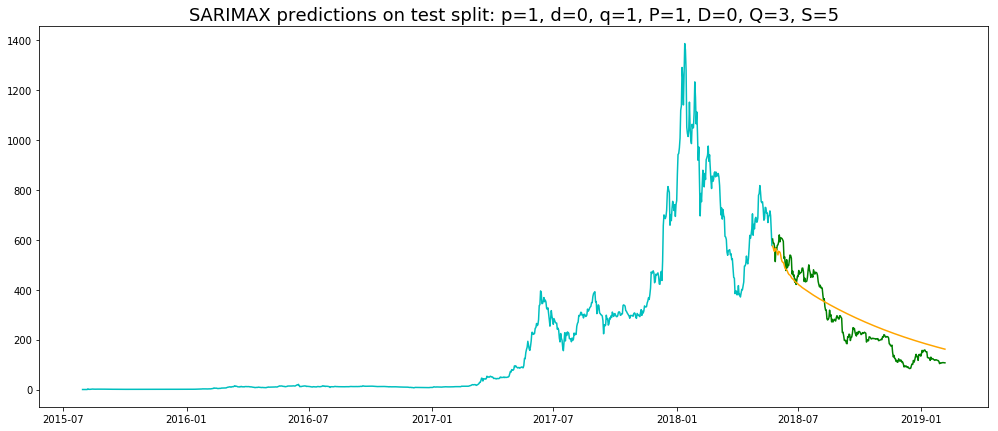

In [72]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,1),              # (p, d, q)
                  seasonal_order=(1, 0, 3, 5)) # (P, D, Q, S)

# Fitting model.
model = sarima.fit()

# Generating predictions
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=1, P=1, D=0, Q=3, S=5', fontsize=18)
plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.8751330026371591


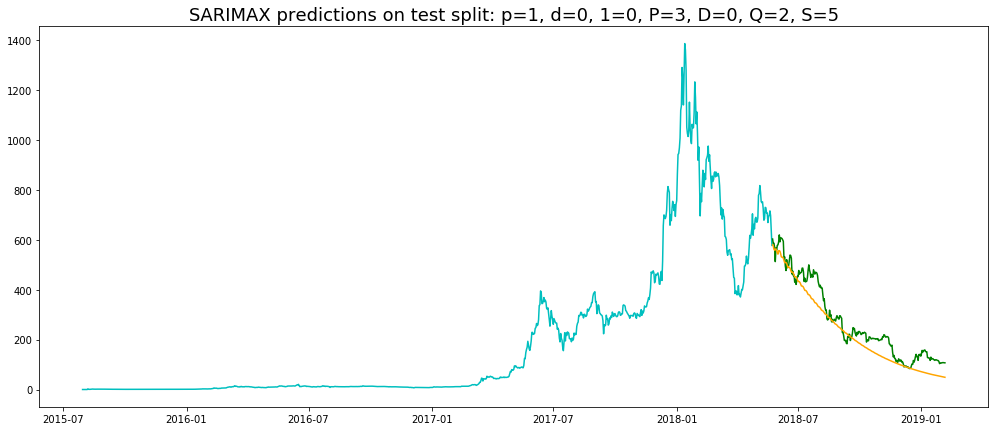

In [73]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(3, 0, 2, 5)) # (P, D, Q, S)

# Fitting model.
model = sarima.fit()

# Generating predictions
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g')

# Plot predicted values in green.
plt.plot(preds, color = 'orange')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, 1=0, P=3, D=0, Q=2, S=5', fontsize=18)
plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.9216039681425557


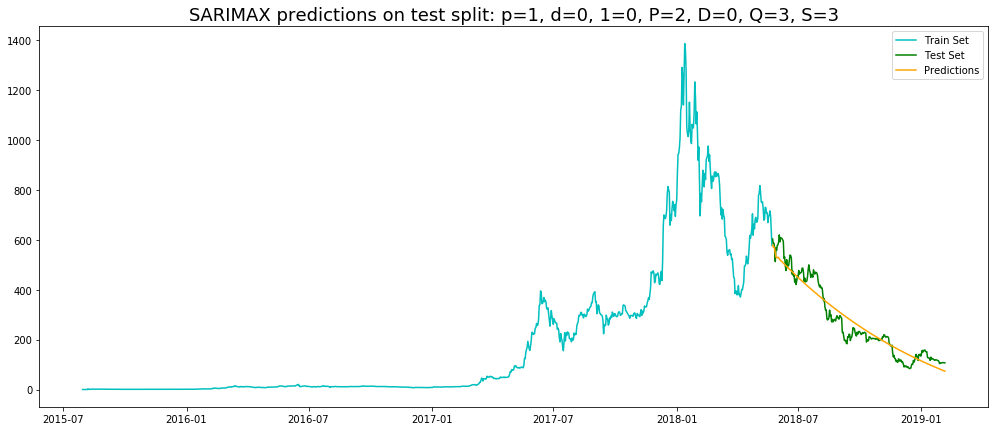

In [74]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,1),              # (p, d, q)
                  seasonal_order=(2, 0, 3, 3)) # (P, D, Q, S)

# Fitting model.
model = sarima.fit()

# Generating predictions
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c', label='Train Set')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g', label='Test Set')

# Plot predicted values in green.
plt.plot(preds, color = 'orange', label='Predictions')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, 1=0, P=2, D=0, Q=3, S=3', fontsize=18)
plt.legend()
plt.show();

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


0.8751330026371591


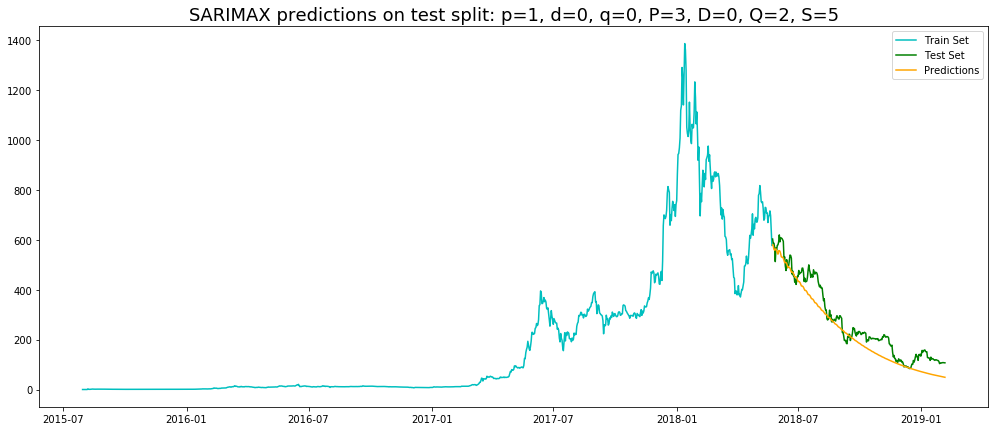

In [75]:
## Instantiating Model
sarima = SARIMAX(endog=eth_train.eth_price,
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(3, 0, 2, 5)) # (P, D, Q, S)

# Fitting model.
model = sarima.fit()

# Generating predictions.
preds = model.predict(eth_test.eth_price.index[0], eth_test.eth_price.index[-1])

print(r2_score(eth_test.eth_price, preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(eth_train.eth_price, color = 'c', label='Train Set')

# Plot testing data in orange.
plt.plot(eth_test.eth_price, color = 'g', label='Test Set')

# Plot predicted values in green.
plt.plot(preds, color = 'orange', label='Predictions')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, q=0, P=3, D=0, Q=2, S=5', fontsize=18)
plt.legend();
plt.show()

Even if the models above have a relative good R2 score, unfortunately, they overfit the training set, as the plot below clearly shows...

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


-0.3946581516162484


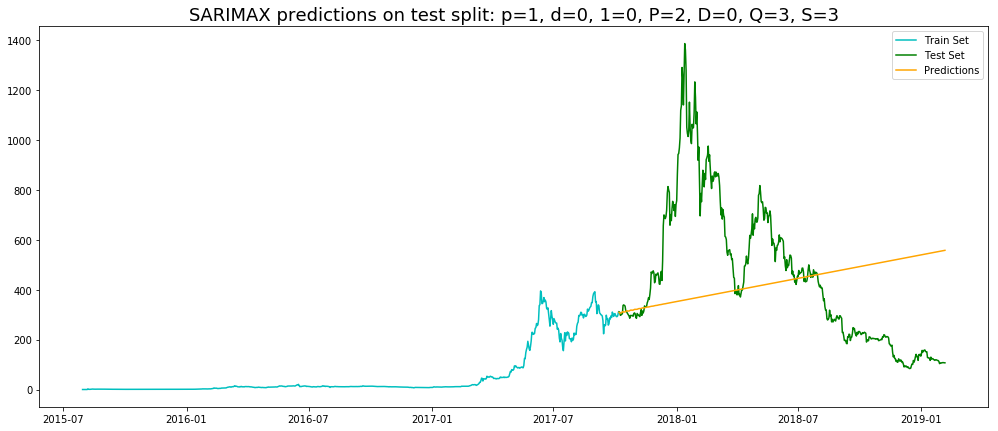

In [76]:
## Instantiating the model
sarima = SARIMAX(endog=df_eth.eth_price[:800],
                  order = (1,2,1),              # (p, d, q)
                  seasonal_order=(2, 0, 3, 3)) # (P, D, Q, S)

# Fitting the model.
model = sarima.fit()

# Generating predictions.
preds = model.predict(df_eth.eth_price.index[800], df_eth.eth_price.index[-1])

print(r2_score(df_eth.eth_price[800:], preds))

# Plot data.
plt.figure(figsize=(17,7))

# Plot training data in blue.
plt.plot(df_eth.eth_price[:800], color = 'c', label='Train Set' )

# Plot testing data in orange.
plt.plot(df_eth.eth_price[800:], color = 'g', label='Test Set')

# Plot predicted values in green.
plt.plot(preds, color = 'orange', label='Predictions')

plt.title(label = 'SARIMAX predictions on test split: p=1, d=0, 1=0, P=2, D=0, Q=3, S=3', fontsize=18)
plt.legend()
plt.show();

**Remarks on regression problem**    
- We tried to predict ETH price based - only - on past ETH price's performance. 
- For the purpose we tried to fit: AR, MA, ARMA, ARIMA, SARIMA models. 
- While we obtained some apparently good result in SARIMA models - R2 scores above 90%! - with the parameters obtained through grid search, we quickly demonstrated that our model does not generalize well and clearly overfits the training set. 
- Therefore, our models have no practical value - they don't do well their job!
- Possible next steps relying on the same family of models could be: trying transforming the input data - e.g. with log function or power transformation - and / or fitting SARIMAX models, with the X standing for Exogenous variable. A SARIMAX model leveraging the 'right' exogenous variables could perform much better than our models. Of course, to identify thexe exogenous variables is not trivial and constitutes the scope of an entire new work!

### Trying to predict percentage change direction: a classification problem

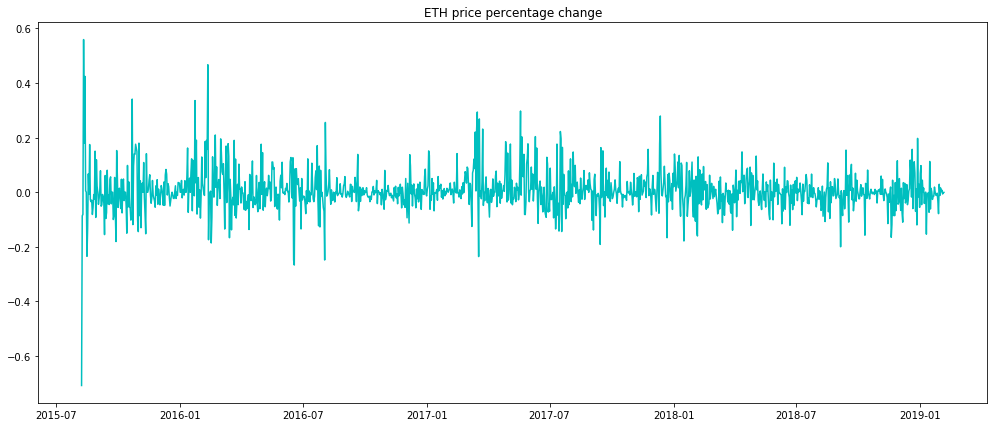

In [77]:
# Plot data.
plt.figure(figsize=(17,7))

# Plot true log price in blue.
plt.plot(df_eth.eth_price.pct_change(), color = 'c')

plt.title('ETH price percentage change');

In [78]:
## Proving stationarity of ETH price percentage change
adfuller(df_eth.eth_price.pct_change()[14:])

(-18.85296928726413,
 0.0,
 2,
 1270,
 {'1%': -3.435509501237317,
  '5%': -2.86381847140403,
  '10%': -2.5679830801661603},
 -3160.272851508259)

In [79]:
## Creating percentage change variable
df_eth['pct_change_label'] = df_eth.eth_price.pct_change()

In [80]:
## Binarizing percentage change variable
df_eth['pct_change_binary_label'] = np.where(df_eth['pct_change_label'] >= 0, 1, 0)

In [81]:
df_eth.head(10)

,UnixTimeStamp,eth_price,pct_change_label,pct_change_binary_label
Date,,,,
2015-07-30,1438214400,0.00,NaN,0
2015-07-31,1438300800,0.00,NaN,0
2015-08-01,1438387200,0.00,NaN,0
2015-08-02,1438473600,0.00,NaN,0
2015-08-03,1438560000,0.00,NaN,0
2015-08-04,1438646400,0.00,NaN,0
2015-08-05,1438732800,0.00,NaN,0
2015-08-06,1438819200,0.00,NaN,0
2015-08-07,1438905600,2.77,inf,1


#### Train Test Split

In [82]:
train_reg   = df_eth.pct_change_label[0:1029]
test_reg    = df_eth.pct_change_label[1029:]
train_class = df_eth.pct_change_binary_label[0:1029]
test_class  = df_eth.pct_change_binary_label[1029:]

In [83]:
from sklearn.metrics import accuracy_score

#### Creating new Data Frame for classification problem

In [84]:
df_classification = pd.DataFrame()

In [85]:
df_classification['pct_change_binary_label'] = df_eth['pct_change_binary_label']

In [86]:
df_classification.head()

,pct_change_binary_label
Date,
2015-07-30,0
2015-07-31,0
2015-08-01,0
2015-08-02,0
2015-08-03,0


#### Modelling with SARIMA - training on the whole dataset

In [87]:
%%time
## Instantiating SARIMA model
sarima = SARIMAX(endog=df_classification['pct_change_binary_label'],
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(2, 2, 0, 7)) # (P, D, Q, S)

# Fitting SARIMA model.
model = sarima.fit()

# Generating predictions.
preds = model.predict()

# Binarizing predictions
preds = np.where(preds>0, 1, 0)

print(accuracy_score(df_classification['pct_change_binary_label'], preds))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.5446775446775447
CPU times: user 1.59 s, sys: 217 ms, total: 1.8 s
Wall time: 416 ms


#### Scoring predictions

In [88]:
from sklearn.metrics import confusion_matrix

confusion_matrix(df_classification['pct_change_binary_label'], preds)

array([[209, 434],
       [152, 492]])

#### Modelling with SARIMA - training on the first 80% observation and testing on test set

In [89]:
%%time
sarima = SARIMAX(endog=df_classification['pct_change_binary_label'][0:1029],
                  order = (1,0,0),              # (p, d, q)
                  seasonal_order=(2, 2, 0, 7)) # (P, D, Q, S)

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on test set.
preds = model.predict(df_classification['pct_change_binary_label'].index[1029],df_classification['pct_change_binary_label'].index[-1] )

preds = np.where(preds>0, 1, 0)

print(accuracy_score(df_classification['pct_change_binary_label'][1029:], preds))

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


0.5038759689922481
CPU times: user 1.76 s, sys: 297 ms, total: 2.05 s
Wall time: 405 ms


**Remarks on classification problem**    
- As for the classification problem, the models that we developed with the same methodology have no practical value: an accuracy score of 50% on predicting the direction of ETH price change means that to flip a coin has the same predictive capabilities than our model!
- Possible improvements to the model are the same that we recommend for the regression models: open the model to exogenous variables, transform our features.

In [90]:
## Grid search code used to identify best parameters used in the model above. 

'''%%time
# Starting accuracy and (P, D, Q, S).

accuratezza = 0 

final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for S in range(15):
    #print(S)
    for P in range(4):
        #print(P)
        for Q in range(4):
            #print(Q)
            for D in range(4):
                #print(D)
                try:
                    # Instantiate SARIMA model.
                    sarima = SARIMAX(df_classification['pct_change_binary_label'],
                                     order = (1, 0, 0),              # (p, d, q)
                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)

                    # Fit SARIMA model.
                    model = sarima.fit()

                    # Generate predictions based on training set.
                    # Start at time period 0 and end at 149.
                    preds = model.predict()
                    preds = np.where(preds>0, 1, 0)


                    # Evaluate predictions.
                    print('The accuracy score for 1, 0, 0 x{},{},{},{} is: {}'.format(P, D, Q, S, accuracy_score(df_classification['pct_change_binary_label'], preds)))

                    # Save for final report.
                    if accuratezza < accuracy_score(df_classification['pct_change_binary_label'], preds): #eth_test.eth_price[-100:], preds[-100:]
                        accuratezza = accuracy_score(df_classification['pct_change_binary_label'], preds) #eth_test.eth_price[-100:], preds[-100:]
                        final_P = P
                        final_D = D
                        final_Q = Q
                        final_S = S


                except:
                    pass

print(f'Our model that maximizes accuracy on the training data is the SARIMA(1, 0, 0)x({final_P},{final_D},{final_Q}, {final_S}).')
print(f'This model has an accuracy score of {accuratezza}.')'''

"%%time\n# Starting accuracy and (P, D, Q, S).\n\naccuratezza = 0 \n\nfinal_P = 0\nfinal_D = 0\nfinal_Q = 0\nfinal_S = 0\n\nfor S in range(15):\n    #print(S)\n    for P in range(4):\n        #print(P)\n        for Q in range(4):\n            #print(Q)\n            for D in range(4):\n                #print(D)\n                try:\n                    # Instantiate SARIMA model.\n                    sarima = SARIMAX(df_classification['pct_change_binary_label'],\n                                     order = (1, 0, 0),              # (p, d, q)\n                                     seasonal_order = (P, D, Q, S)) # (P, D, Q, S)\n\n                    # Fit SARIMA model.\n                    model = sarima.fit()\n\n                    # Generate predictions based on training set.\n                    # Start at time period 0 and end at 149.\n                    preds = model.predict()\n                    preds = np.where(preds>0, 1, 0)\n\n\n                    # Evaluate predictions.\n   

The accuracy score for 1, 0, 0 x0,1,0,2 is: 0.533022533022533
The accuracy score for 1, 0, 0 x2,3,1,2 is: 0.5213675213675214
The accuracy score for 1, 0, 0 x3,3,1,2 is: 0.5252525252525253
The accuracy score for 1, 0, 0 x0,1,0,3 is: 0.5415695415695416
The accuracy score for 1, 0, 0 x2,2,0,7 is: 0.5446775446775447
The accuracy score for 1, 0, 0 x2,3,0,7 is: 0.5314685314685315
The accuracy score for 1, 0, 0 x2,2,0,3 is: 0.5407925407925408
The accuracy score for 1, 0, 0 x2,3,0,4 is: 0.5252525252525253
The accuracy score for 1, 0, 0 x1,1,0,5 is: 0.5213675213675214
The accuracy score for 1, 0, 0 x1,3,0,5 is: 0.5236985236985237
The accuracy score for 1, 0, 0 x2,3,0,5 is: 0.5213675213675214
The accuracy score for 1, 0, 0 x2,3,0,5 is: 0.5213675213675214
The accuracy score for 1, 0, 0 x3,3,0,5 is: 0.5229215229215229
The accuracy score for 1, 0, 0 x0,1,0,7 is: 0.5337995337995338
The accuracy score for 1, 0, 0 x1,1,0,7 is: 0.5361305361305362
The accuracy score for 1, 0, 0 x1,3,0,7 is: 0.533022533022533
The accuracy score for 1, 0, 0 x2,3,1,7 is: 0.5236985236985237
The accuracy score for 1, 0, 0 x3,3,0,7 is: 0.5314685314685315
The accuracy score for 1, 0, 0 x3,2,0,7 is: 0.5252525252525253
The accuracy score for 1, 0, 0 x3,3,1,7 is: 0.5275835275835276